# JPMC Take-Home Project: Classification and Segmentation

## Required imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, metrics
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix

## Directory paths

In [2]:
ROOT_DIR = Path().resolve().parent
CODE_DIR = ROOT_DIR / "code"
DATA_DIR = ROOT_DIR / "data"

## Read and preprocess dataset

In [3]:
# Read all the column names and eliminate the newline character from each line
with open(DATA_DIR / "census-bureau.columns", "r") as file:
    colnames = [x[:-1] for x in file.readlines()]

In [4]:
df = pd.read_csv(DATA_DIR / "census-bureau.data", names=colnames)

In [5]:
df.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [6]:
# Value counts for all columns
for col in df.columns:
    print(df[col].value_counts())
    print()

age
34    3489
35    3450
36    3353
31    3351
33    3340
      ... 
85     423
86     348
87     301
88     241
89     195
Name: count, Length: 91, dtype: int64

class of worker
Not in universe                   100245
Private                            72028
Self-employed-not incorporated      8445
Local government                    7784
State government                    4227
Self-employed-incorporated          3265
Federal government                  2925
Never worked                         439
Without pay                          165
Name: count, dtype: int64

detailed industry recode
0     100684
33     17070
43      8283
4       5984
42      4683
45      4482
29      4209
37      4022
41      3964
32      3596
35      3380
39      2937
34      2765
44      2549
2       2196
11      1764
50      1704
40      1651
47      1644
38      1629
24      1503
12      1350
19      1346
30      1181
31      1178
25      1084
9        993
22       952
36       945
13       899
1        

In [7]:
# NaN values for all columns
df.isnull().sum()

age                                             0
class of worker                                 0
detailed industry recode                        0
detailed occupation recode                      0
education                                       0
wage per hour                                   0
enroll in edu inst last wk                      0
marital stat                                    0
major industry code                             0
major occupation code                           0
race                                            0
hispanic origin                               874
sex                                             0
member of a labor union                         0
reason for unemployment                         0
full or part time employment stat               0
capital gains                                   0
capital losses                                  0
dividends from stocks                           0
tax filer stat                                  0


In [8]:
df[df["hispanic origin"].isna()]["race"].value_counts()

race
White                          737
Black                           94
Amer Indian Aleut or Eskimo     15
Other                           14
Asian or Pacific Islander       14
Name: count, dtype: int64

In [9]:
df[~df["hispanic origin"].isna()]["race"].value_counts()

race
White                          166628
Black                           20321
Asian or Pacific Islander        5821
Other                            3643
Amer Indian Aleut or Eskimo      2236
Name: count, dtype: int64

In [10]:
df["label_binary"] = df["label"].apply(lambda x: 1 if "+" in x else 0)
df["label_binary"].value_counts()

label_binary
0    187141
1     12382
Name: count, dtype: int64

In [11]:
df.fillna({"hispanic origin": "Do not know"}, inplace=True)
df.isnull().sum()

age                                           0
class of worker                               0
detailed industry recode                      0
detailed occupation recode                    0
education                                     0
wage per hour                                 0
enroll in edu inst last wk                    0
marital stat                                  0
major industry code                           0
major occupation code                         0
race                                          0
hispanic origin                               0
sex                                           0
member of a labor union                       0
reason for unemployment                       0
full or part time employment stat             0
capital gains                                 0
capital losses                                0
dividends from stocks                         0
tax filer stat                                0
region of previous residence            

In [12]:
df["hispanic origin"].value_counts()

hispanic origin
All other                    171907
Mexican-American               8079
Mexican (Mexicano)             7234
Central or South American      3895
Puerto Rican                   3313
Other Spanish                  2485
Do not know                    1180
Cuban                          1126
Chicano                         304
Name: count, dtype: int64

## Classification

In [13]:
# Extract labels, weights, and remaining features
X_cols = [c for c in df.columns if c not in ["weight", "label", "label_binary"]]
X = df[X_cols]
y = df["label_binary"]
w = df["weight"]

In [14]:
X.dtypes

age                                            int64
class of worker                               object
detailed industry recode                       int64
detailed occupation recode                     int64
education                                     object
wage per hour                                  int64
enroll in edu inst last wk                    object
marital stat                                  object
major industry code                           object
major occupation code                         object
race                                          object
hispanic origin                               object
sex                                           object
member of a labor union                       object
reason for unemployment                       object
full or part time employment stat             object
capital gains                                  int64
capital losses                                 int64
dividends from stocks                         

In [15]:
# Extract indices of categorical features
special_cols = ["detailed industry recode", "detailed occupation recode", "own business or self employed", "veterans benefits"]
special_col_indices = np.array([c in special_cols for c in X.columns])
categorical_features_indices = np.where(((X.dtypes != float) & (X.dtypes != int)) | special_col_indices)[0]

In [16]:
categorical_features_indices

array([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37])

### Train-Val-Test Split

In [17]:
# Train : Validation : Test = 60 : 20 : 20
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, random_state=12)
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_train, y_train, w_train, test_size=0.25, random_state=34)

### Load or train CatBoostClassifier

In [18]:
clf = CatBoostClassifier()
clf.load_model("income_classifier.cbm")

**Note**: Uncomment the below two cells to retrain the model.

In [19]:
"""
clf = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=335,
    logging_level='Silent'
)
"""

"\nclf = CatBoostClassifier(\n    custom_loss=[metrics.Accuracy()],\n    random_seed=335,\n    logging_level='Silent'\n)\n"

In [20]:
"""
clf.fit(
    X_train, y_train,
    sample_weight=w_train,
    cat_features=categorical_features_indices,
    logging_level='Verbose',
    eval_set=(X_val, y_val)
)
"""

"\nclf.fit(\n    X_train, y_train,\n    sample_weight=w_train,\n    cat_features=categorical_features_indices,\n    logging_level='Verbose',\n    eval_set=(X_val, y_val)\n)\n"

### Metrics

In [21]:
y_train_pred = clf.predict(X_train)
y_train_prob = clf.predict_proba(X_train)
y_val_pred = clf.predict(X_val)
y_val_prob = clf.predict_proba(X_val)
y_test_pred = clf.predict(X_test)
y_test_prob = clf.predict_proba(X_test)

#### Accuracy

In [22]:
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred, sample_weight=w_train):.4f}")
print(f"Validation accuracy: {accuracy_score(y_val, y_val_pred, sample_weight=w_val):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred, sample_weight=w_test):.4f}")

Train accuracy: 0.9631
Validation accuracy: 0.9569
Test accuracy: 0.9558


#### ROC-AUC

In [23]:
print(f"Train ROC-AUC: {roc_auc_score(y_train, y_train_prob[:,1], sample_weight=w_train):.4f}")
print(f"Validation ROC-AUC: {roc_auc_score(y_val, y_val_prob[:,1], sample_weight=w_val):.4f}")
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_test_prob[:,1], sample_weight=w_test):.4f}")

Train ROC-AUC: 0.9632
Validation ROC-AUC: 0.9528
Test ROC-AUC: 0.9534


In [24]:
fpr_train, tpr_train, thresh_train = roc_curve(y_train, y_train_prob[:,1], sample_weight=w_train)
fpr_val, tpr_val, thresh_val = roc_curve(y_val, y_val_prob[:,1], sample_weight=w_val)
fpr_test, tpr_test, thresh_test = roc_curve(y_test, y_test_prob[:,1], sample_weight=w_test)

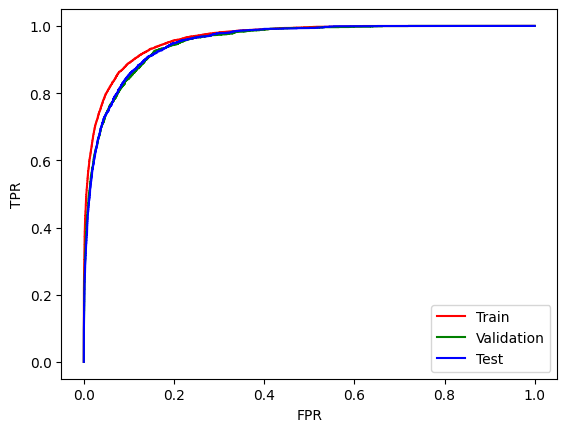

In [25]:
plt.figure(1)
plt.plot(fpr_train, tpr_train, "-r", label="Train")
plt.plot(fpr_val, tpr_val, "-g", label="Validation")
plt.plot(fpr_test, tpr_test, "-b", label="Test")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

#### Confusion Matrix, Precision, Recall

In [28]:
# Row: Actual, Column: Predicted
train_cm = confusion_matrix(y_train, y_train_pred, sample_weight=w_train, normalize="all")
val_cm = confusion_matrix(y_val, y_val_pred, sample_weight=w_val, normalize="all")
test_cm = confusion_matrix(y_test, y_test_pred, sample_weight=w_test, normalize="all")
print("Train confusion matrix:")
print(train_cm)
print("Validation confusion matrix:")
print(val_cm)
print("Test confusion matrix:")
print(test_cm)

Train confusion matrix:
[[0.92836341 0.00752964]
 [0.02939348 0.03471347]]
Validation confusion matrix:
[[0.92517945 0.01014331]
 [0.03296674 0.0317105 ]]
Test confusion matrix:
[[0.92498517 0.01176484]
 [0.03238755 0.03086244]]


In [29]:
labels = ["Train", "Validation", "Test"]
matrices = [train_cm, val_cm, test_cm]

for label, cm in zip(labels, matrices):
    tp = cm[1, 1]
    fp = cm[0, 1]
    fn = cm[1, 0]
    prec = tp/(tp+fp)
    rec = tp/(tp+fn)
    print(f"{label} data: Precision = {prec:.4f}, Recall = {rec:.4f}")

Train data: Precision = 0.8218, Recall = 0.5415
Validation data: Precision = 0.7576, Recall = 0.4903
Test data: Precision = 0.7240, Recall = 0.4879


In [30]:
# Changing the decision threshold
for p_thresh in np.arange(0.1, 0.6, 0.1):
    y_train_pred_thresh = (y_train_prob[:,1] >= p_thresh).astype(int)
    y_val_pred_thresh = (y_val_prob[:,1] >= p_thresh).astype(int)
    y_test_pred_thresh = (y_test_prob[:,1] >= p_thresh).astype(int)

    train_cm = confusion_matrix(y_train, y_train_pred_thresh, sample_weight=w_train, normalize="all")
    val_cm = confusion_matrix(y_val, y_val_pred_thresh, sample_weight=w_val, normalize="all")
    test_cm = confusion_matrix(y_test, y_test_pred_thresh, sample_weight=w_test, normalize="all")

    labels = ["Train", "Validation", "Test"]
    matrices = [train_cm, val_cm, test_cm]

    print(f"Threshold = {p_thresh:.1f}:")
    print("-------------------")
    for label, cm in zip(labels, matrices):
        tp = cm[1, 1]
        fp = cm[0, 1]
        fn = cm[1, 0]
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)
        print(f"{label} data: Precision = {prec:.4f}, Recall = {rec:.4f}")
    print()

Threshold = 0.1:
-------------------
Train data: Precision = 0.4060, Recall = 0.8733
Validation data: Precision = 0.3882, Recall = 0.8276
Test data: Precision = 0.3767, Recall = 0.8452

Threshold = 0.2:
-------------------
Train data: Precision = 0.5532, Recall = 0.7787
Validation data: Precision = 0.5212, Recall = 0.7240
Test data: Precision = 0.5048, Recall = 0.7352

Threshold = 0.3:
-------------------
Train data: Precision = 0.6648, Recall = 0.6961
Validation data: Precision = 0.6164, Recall = 0.6369
Test data: Precision = 0.5989, Recall = 0.6468

Threshold = 0.4:
-------------------
Train data: Precision = 0.7508, Recall = 0.6119
Validation data: Precision = 0.6981, Recall = 0.5587
Test data: Precision = 0.6664, Recall = 0.5740

Threshold = 0.5:
-------------------
Train data: Precision = 0.8218, Recall = 0.5415
Validation data: Precision = 0.7576, Recall = 0.4903
Test data: Precision = 0.7240, Recall = 0.4879



#### Feature Importance

In [36]:
feature_importance = pd.DataFrame(np.array(clf.get_feature_importance(prettified=True)), columns=["feature", "importance"])
feature_importance["importance"] = feature_importance["importance"].apply(lambda x: np.round(x, 3))
feature_importance

,feature,importance
0,age,12.298
1,weeks worked in year,9.575
2,hispanic origin,9.077
3,family members under 18,9.054
4,veterans benefits,9.012
5,education,6.062
6,sex,4.859
7,detailed occupation recode,4.640
8,marital stat,4.387
9,tax filer stat,4.148


In [31]:
# Uncomment this line to save a new model (will overwrite the existing model)
# clf.save_model("income_classifier.cbm")

## References
1. [https://catboost.ai/docs/en/concepts/tutorials](https://catboost.ai/docs/en/concepts/tutorials)
2. [https://github.com/catboost/tutorials](https://github.com/catboost/tutorials)